# Main

## Train

In [3]:
model_name = "bert-base-cased"
epochs = 5
batch_size = 8

In [4]:
# load basic library
import os
import random
import numpy as np
import pickle
from tqdm import tqdm

# load torch library
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup,
)

# custum module
from tools import *

# keep reandom seed
seed_val = 0
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# check gpu
device = get_device()

# setting path
metric_path, model_path, history_path, fig_path = setting_path(
    model_name, batch_size, epochs, mode="train"
)

path = "./data/train_valid_split/level_1/"
with open(os.path.join(path, "X_tr.pkl"), "rb") as f:
    X_tr = pickle.load(f)
with open(os.path.join(path, "X_va.pkl"), "rb") as f:
    X_va = pickle.load(f)
with open(os.path.join(path, "y_tr.pkl"), "rb") as f:
    y_tr = pickle.load(f)
with open(os.path.join(path, "y_va.pkl"), "rb") as f:
    y_va = pickle.load(f)

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti

metric_path: /home/lichang/projects/ai_cup-movie/result/bert-base-cased_bs_8_epo5/train/metrics
model_path: /home/lichang/projects/ai_cup-movie/result/bert-base-cased_bs_8_epo5/train/model
history_path: /home/lichang/projects/ai_cup-movie/result/bert-base-cased_bs_8_epo5/train/history
fig_path: /home/lichang/projects/ai_cup-movie/result/bert-base-cased_bs_8_epo5/train/figures


In [5]:
X_tr = X_tr[:1000]
X_va = X_va[:1000]
y_tr = y_tr[:1000]
y_va = y_va[:1000]

### tokenizing

In [6]:
# tokenize
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

input_ids_tr, attention_masks_tr, labels_tr = tokenizing(
    X_tr.values, y_tr.values, tokenizer
)
input_ids_va, attention_masks_va, labels_va = tokenizing(
    X_va.values, y_va.values, tokenizer
)

check average token length

**max_len = 512:**

```python
print(np.mean(token_length))
print(np.max(token_length))
print(np.min(token_length))
print(np.std(token_length))
```

```text
231.8667348329925
512
4
153.99549015975495
```

**max_len = 400:**

```python
print(np.mean(token_length))
print(np.max(token_length))
print(np.min(token_length))
print(np.std(token_length))
```

```text
215.33452624403546
400
4
127.15932762513401
```


### dataset

In [7]:
# Holdout dataset
Trainset = TensorDataset(input_ids_tr, attention_masks_tr, labels_tr)
Validset = TensorDataset(input_ids_va, attention_masks_va, labels_va)

### training

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.4,
    attention_probs_dropout_prob=0.4,
)
model.to(device)

# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
no_decay = ["bias", "LayerNorm.weight"]

# Separate the `weight` parameters from the `bias` parameters.
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01.
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay_rate": 0.01,
    },
    # Filter for parameters which *do* include those.
    {
        "params": [
            p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)
        ],
        "weight_decay_rate": 0.0,
    },
]

# Note - `optimizer_grouped_parameters` only includes the parameter values, not
# the names.

N_train = len(Trainset)
N_test = len(Validset)
print("Num of train samples:", N_train)
print("Num of valid samples:", N_test)
print()

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=4e-5,  # args.learning_rate - default is 5e-5, our notebook had 2e-5
)

train_loader = DataLoader(Trainset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(Validset, shuffle=False, batch_size=batch_size)

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=total_steps * 0.1, num_training_steps=total_steps
)

history, best_epoch = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    N_train=N_train,
    N_test=N_test,
    device=device,
    scheduler=scheduler,
    path=model_path,
    epochs=epochs,
    patience=3,
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Num of train samples: 1000
Num of valid samples: 1000

training acc: 0.51
training loss: 0.73
training auc: 0.50
-------------------------
train acc: 0.63
train loss: 0.68
train auc: 0.73
-------------------------
valid acc: 0.60
valid loss: 0.68
valid auc: 0.70
-------------------------
Validation loss decreased (inf --> 0.684132).  Saving model ...
training acc: 0.60
training loss: 0.65
training auc: 0.66
-------------------------
train acc: 0.81
train loss: 0.43
train auc: 0.90
-------------------------
valid acc: 0.77
valid loss: 0.49
valid auc: 0.85
-------------------------
Validation loss decreased (0.684132 --> 0.491430).  Saving model ...
training acc: 0.79
training loss: 0.46
training auc: 0.87
-------------------------
train acc: 0.90
train loss: 0.25
train auc: 0.97
-------------------------
valid acc: 0.85
valid loss: 0.37
valid auc: 0.92
-------------------------
Validation loss decreased (0.491430 --> 0.373521).  Saving model ...
training acc: 0.85
training loss: 0.39
tr

In [9]:
# save trainin_history
with open(os.path.join(history_path, "hist.pkl"), "wb") as f:
    pickle.dump(history, f)

In [10]:
# metric
tr_metric = final_metric(history, mtype="train", best_epoch=best_epoch)
va_metric = final_metric(history, mtype="valid", best_epoch=best_epoch)
save_metrics(metric_path, "train", best_epoch=None, **tr_metric)
save_metrics(metric_path, "valid", best_epoch=None, **va_metric)


[train average]

ACC: 0.9
LOSS: 0.25

Recall: 0.92
Specificity: 0.89
Precision: 0.9
NPV: 0.91

F1: 0.91
MCC: 0.81
AUC: 0.97


[valid average]

ACC: 0.85
LOSS: 0.37

Recall: 0.89
Specificity: 0.8
Precision: 0.84
NPV: 0.87

F1: 0.86
MCC: 0.7
AUC: 0.92



In [11]:
best_epoch

2

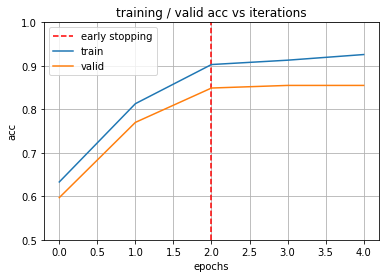

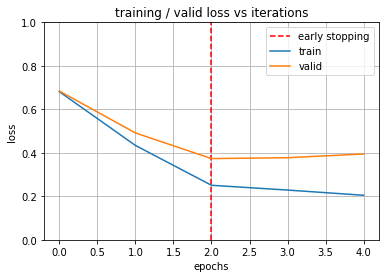

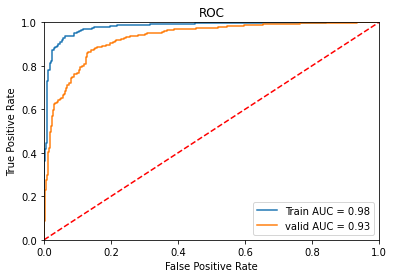

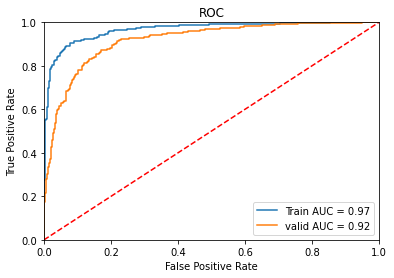

In [12]:
# plot learning curve
plot_lr("acc", history, fig_path=fig_path, best_epoch=best_epoch, show=True)
plot_lr("loss", history, fig_path=fig_path, best_epoch=best_epoch, show=True)
plot_roc(history, fig_path=fig_path, best_epoch=None, show=True)
plot_roc(history, fig_path=fig_path, best_epoch=best_epoch, show=True)

# Evaluate on test

In [10]:
model_name = "bert-base-cased"
epochs = 3
batch_size = 4

In [11]:
# load basic library
import os
import random
import numpy as np
import pickle
from tqdm import tqdm

# load torch library
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup,
)

# custum module
from tools import *

# keep reandom seed
seed_val = 0
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# check gpu
device = get_device()

# setting path
metric_path, model_path, history_path, fig_path = setting_path(
    model_name, batch_size, epochs, mode="test"
)


# load data
with open("./data/train_test_split/X_te.pkl", "rb") as f:
    X_test = pickle.load(f)
with open("./data/train_test_split/y_te.pkl", "rb") as f:
    y_test = pickle.load(f)

No GPU available, using the CPU instead.

metric_path: D:\user\Documents\N26091194\Projects\ai_cup-movie\result\bert-base-cased_bs_4_epo3\test\metrics
model_path: D:\user\Documents\N26091194\Projects\ai_cup-movie\result\bert-base-cased_bs_4_epo3\train\model
history_path: D:\user\Documents\N26091194\Projects\ai_cup-movie\result\bert-base-cased_bs_4_epo3\test\history
fig_path: None


In [12]:
X_test = X_test[:50]
y_test = y_test[:50]

In [13]:
# tokenize
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
input_ids_te, attention_masks_te, labels_te = tokenizing(
    X_test.values, y_test.values, tokenizer
)

In [15]:
testdataset = TensorDataset(input_ids_te, attention_masks_te, labels_te)

In [16]:
print("test dataset:", len(testdataset))

50

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)
model.to(device)

PATH = os.path.join(model_path, "model.pkl")
model.load_state_dict(torch.load(PATH))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

<All keys matched successfully>

In [19]:
N_test = len(testdataset)

test_loader = DataLoader(testdataset, shuffle=False, batch_size=16)

history_2 = eval_model(
    model=model,
    test_loader=test_loader,
    N_test=N_test,
    device=device,
)

test loss: 0.67
test acc: 0.54
-------------------------


In [20]:
# save trainin_history
with open(os.path.join(history_path, "hist.pkl"), "wb") as f:
    pickle.dump(history_2, f)

In [21]:
# save metric
te_metric = final_metric(history_2, mtype="test")
save_metrics(metric_path, "test", best_epoch=None, **te_metric)


[test average]

ACC: 0.54
LOSS: 0.67

Recall: 0.042
Specificity: 1.0
Precision: 1.0
NPV: 0.53

F1: 0.08
MCC: 0.15
AUC: 0.49



# Prediction

In [22]:
model_name = "bert-base-cased"
epochs = 3
batch_size = 4
mode = "predict"

In [23]:
# load basic library
import os
import random
import numpy as np
import pickle
from tqdm import tqdm
import pandas as pd

# load torch library
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup,
)

# custum module
from tools import *

# keep reandom seed
seed_val = 0
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# check gpu
device = get_device()

# setting path
metric_path, model_path, history_path, fig_path = setting_path(
    model_name, batch_size, epochs, mode="test"
)

# load data
with open("./data/test_rm_br.pkl", "rb") as f:
    test = pickle.load(f)
test_data = test["review"].values

No GPU available, using the CPU instead.

metric_path: D:\user\Documents\N26091194\Projects\ai_cup-movie\result\bert-base-cased_bs_4_epo3\test\metrics
model_path: D:\user\Documents\N26091194\Projects\ai_cup-movie\result\bert-base-cased_bs_4_epo3\train\model
history_path: D:\user\Documents\N26091194\Projects\ai_cup-movie\result\bert-base-cased_bs_4_epo3\test\history
fig_path: None


In [24]:
test = test[:50]

In [25]:
test_data = test["review"].values

In [26]:
# check gpu
device = get_device()

# setting path
metric_path, model_path, _, _ = setting_path(model_name, batch_size, epochs, mode)

# tokenize
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
input_ids, attention_masks, _ = tokenizing(test_data, None, tokenizer)

# dataset
testdataset = TensorDataset(input_ids, attention_masks)
print("Prediction dataset:", len(testdataset))

No GPU available, using the CPU instead.

metric_path: D:\user\Documents\N26091194\Projects\ai_cup-movie\result\bert-base-cased_bs_4_epo3\predict\metrics
model_path: D:\user\Documents\N26091194\Projects\ai_cup-movie\result\bert-base-cased_bs_4_epo3\train\model
history_path: None
fig_path: None
Prediction dataset: 50


In [28]:
# load in model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)
model.to(device)
PATH = os.path.join(model_path, "model.pkl")
model.load_state_dict(torch.load(PATH))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

<All keys matched successfully>

In [29]:
# loader
test_loader = DataLoader(testdataset, shuffle=False, batch_size=16)

In [30]:
# prediction
pred = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        output = model(b_input_ids, attention_mask=b_input_mask)
        logits = output[0]

        _, yhat = torch.max(logits.data, 1)

        pred.extend(yhat.cpu().detach().numpy())

In [31]:
print("Answer and prediction have same length:", len(pred) == len(test))

Answer and prediction have same length: True


In [32]:
# save result
path = os.path.abspath(os.path.join(metric_path, ".."))
print("output:", path)
submission = pd.DataFrame({"ID": test["ID"].values, "sentiment": pred})
submission.to_csv(os.path.join(path, "submission.csv"), encoding="utf-8", index=False)

output: D:\user\Documents\N26091194\Projects\ai_cup-movie\result\bert-base-cased_bs_4_epo3\predict
